In [10]:
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt
sns.set(context='talk')
%matplotlib inline

In [3]:
# https://people.duke.edu/~ccc14/sta-663/PyStan.html
import pystan


In [4]:
model_code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

In [6]:
data = { 'n': 100, 'y': 61, }

fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77 NOW.


In [7]:
print(fit)

Inference for Stan model: anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.61  2.7e-3   0.04   0.52   0.58   0.61   0.64   0.69    277    1.0
lp__ -70.17    0.09    0.6 -71.87 -70.29 -69.92 -69.77 -69.74     48   1.02

Samples were drawn using NUTS at Sat Apr  8 19:33:06 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
coin_dict = fit.extract()
coin_dict.keys()

odict_keys(['p', 'lp__'])

/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


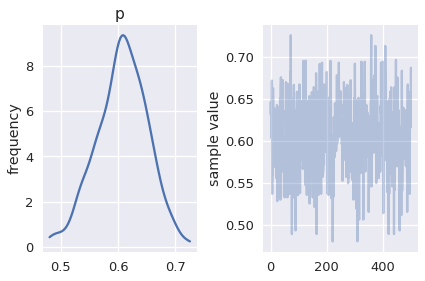

In [11]:
fit.plot('p');
plt.tight_layout()

In [12]:
# https://pystan.readthedocs.io/en/latest/getting_started.html#prerequisites
schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    real eta[J];
}
transformed parameters {
    real theta[J];
    for (j in 1:J)
    theta[j] <- mu + tau * eta[j];
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

fit = pystan.stan(model_code=schools_code, data=schools_dat,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95013624776d537c3cd7cd4d641c30e0 NOW.


In [13]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)

In [20]:
len(mu)

2000

In [21]:
print(fit)

Inference for Stan model: anon_model_95013624776d537c3cd7cd4d641c30e0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          8.2    0.18   4.93  -1.09   4.78   8.05  11.31  18.81    753   1.01
tau        6.24    0.19   5.16   0.17   2.34   4.97   8.92  19.61    756   1.01
eta[0]     0.38    0.02   0.94  -1.51  -0.26   0.38    1.0   2.25   1519    1.0
eta[1]    -0.01    0.02   0.86  -1.68  -0.58  -0.01   0.55   1.75   1469    1.0
eta[2]    -0.22    0.02   0.92  -2.01  -0.85  -0.23   0.41   1.54   1558    1.0
eta[3]  -5.6e-3    0.02    0.9  -1.72  -0.62  -0.03   0.56   1.83   1568    1.0
eta[4]    -0.34    0.02   0.85  -1.98  -0.91  -0.36   0.21   1.35   1678    1.0
eta[5]    -0.24    0.02   0.87  -1.95  -0.85  -0.23   0.31   1.54   1680    1.0
eta[6]     0.29    0.02   0.88  -1.48   -0.3   0.32    0.9   1.99   1601    1.0
eta[7]     0.

/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


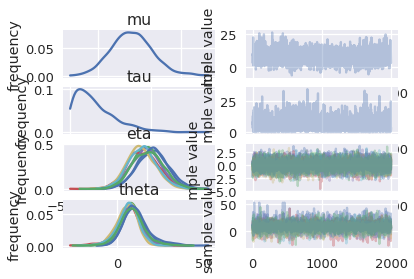

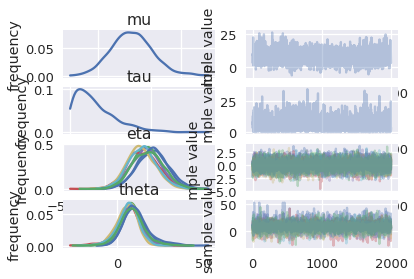

In [22]:
fit.plot()

In [42]:
flip_code = """
functions {}
data {
    int<lower=0> N; // number of students
    real pobs; // observed proportion
    //int x; // observed number of students who reply yes 
    // do we need to pass in observed value for each student?
}
transformed data {} // only evaluated once
parameters {
    real<lower=0,upper=1> p;
}
transformed parameters { // executed once per iteration
    //real val[N]; // declared here instead of model to make it exposed to generated quantities
} 
model {
    //int<lower=0,upper=1> truths[N];
    int truths[N]; // true cheating status
    int first_flips[N]; // first coin flip
    int second_flips[N]; // second coin flip
    real val[N]; // observed value. real so that can do floating point division.
    
    p ~ uniform(0,1);
    for (i in 1:N) {
        truths[i] ~ bernoulli(p);
        first_flips[i] ~ bernoulli(0.5);
        second_flips[i] ~ bernoulli(0.5);
        val[i] = first_flips[i] * truths[i] + (1 - first_flips[i])*second_flips[i];
    }
    pobs = sum(val) / N; // note that want to force floating point division here
    //x = sum(val);
}
generated quantities {
    //pobs = sum(val) / N;
}
"""

N=100.
x=35.
pobs=x/N
flip_data = {'N': N, 'pobs': pobs }

flip_fit = pystan.stan(model_code=flip_code, data=flip_data,
                  iter=1000, chains=4)

ValueError: Failed to parse Stan model 'anon_model_9db1e01b1721a4e4e70a05b89eeea5d9'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Warning (non-fatal):
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If it does, you need to include a target += statement with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    truths[i] ~ bernoulli(...)
Warning (non-fatal):
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If it does, you need to include a target += statement with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    first_flips[i] ~ bernoulli(...)
Warning (non-fatal):
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If it does, you need to include a target += statement with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    second_flips[i] ~ bernoulli(...)
attempt to assign variable in wrong block. left-hand-side variable origin=data

ERROR at line 30

 28:            val[i] = first_flips[i] * truths[i] + (1 - first_flips[i])*second_flips[i];
 29:        }
 30:        pobs = sum(val) / N; // note that want to force floating point division here
                  ^
 31:        //x = sum(val);

PARSER EXPECTED: <expression assignable to left-hand side>


In [45]:
flip_code = """
functions {}
data {
    int<lower=0> N; // number of students
    //real pobs; // observed proportion
    //int x; // observed number of students who reply yes 
    // do we need to pass in observed value for each student?
}
transformed data {} // only evaluated once
parameters {
    real<lower=0,upper=1> p;
}
transformed parameters { // executed once per iteration
    //real val[N]; // declared here instead of model to make it exposed to generated quantities
} 
model {
    //int<lower=0,upper=1> truths[N];
    real pobs; // observed proportion
    int truths[N]; // true cheating status
    int first_flips[N]; // first coin flip
    int second_flips[N]; // second coin flip
    real val[N]; // observed value. real so that can do floating point division.
    
    p ~ uniform(0,1);
    for (i in 1:N) {
        truths[i] ~ bernoulli(p);
        first_flips[i] ~ bernoulli(0.5);
        second_flips[i] ~ bernoulli(0.5);
        val[i] = first_flips[i] * truths[i] + (1 - first_flips[i])*second_flips[i];
    }
    //pobs = sum(val) / N; // note that want to force floating point division here
    //x = sum(val);
}
generated quantities {
    //pobs = sum(val) / N;
}
"""

N=100
x=35.
pobs=x/N
flip_data = {'N': N, 'pobs': pobs }

flip_fit = pystan.stan(model_code=flip_code, data=flip_data,
                  iter=100, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67bbc1493b9dbaeaf3e6b81aff4b3ebd NOW.


RuntimeError: Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 26: bernoulli_log: n is -2147483648, but must be in the interval [0, 1]
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.



Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
